# Hidden Markov Model for Regime Detection

## Executive Summary

In this project i developed a regime-aware tactical allocation between US equities (SPY) and Gold (GLD) using Hidden Markov Models (HMM). The main idea is: equity return dynamics are driven by latent regimes (risk-on vs risk-off). If we can infer the probability of being in a stressed regime, we can proactively tilt toward the defensive asset (Gold) to reduce drawdowns while preserving long-term growth.

**Why SPY + GLD?**
- Structural diversification: Low or sometimes even negative correlation in crises.
- Liquidity and investability: Both are large, tradeable ETFs.
- Interpretability: Clear “growth” vs “defensive” roles.

**Methodology**:
1. Data ingestion & weekly log-return construction.
2. Baseline: passive 50/50 allocation between SPY and GLD.
3. Gaussian HMM (2 states) on SPY returns to explore regime switching dynamics.
3. Upgrade emissions to Gaussian Mixture (GMM-HMM) to capture fat tails and skew.
4. Add a second feature (rolling volatility) to test multivariate improvement.
5. Fair benchmark comparison using total return index (dividends matter for equities).

**Evaluation Lens**:
- CAGR (compounded annual growth rate) for growth.
- Max and Average Drawdown for capital preservation.
- Sharpe Ratio (simplified, rf = 0) for risk-adjusted efficiency.

**Key Caveats**:
- No transaction costs or slippage modeled.
- Hyperparameters chosen heuristically 
- Simple two-asset universe.

**Results**: 
- Outperformed static 50/50 SPY–GLD benchmark with +2.2% CAGR and +6.6% Sharpe ratio improvement, indicating superior risk-adjusted returns.
- Reduced drawdowns vs SPY benchmark, achieving –15.3% max drawdown and –6.7% average drawdown, improving downside protection.
- Mixture-based univariate HMM proved most effective, capturing regime shifts and enhancing drawdown efficiency.
- Multivariate extension (adding rolling volatility) did not produce incremental performance gains.
- Dividend-adjusted total return benchmarks confirmed robustness of results, ruling out distortions from ignoring equity income.

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Download Data
We source raw daily OHLCV data for SPY (US equity proxy) and GLD (gold) via `yfinance`.

Design Choices:
- Start date set to 2000-01-01 to cover multiple macro regimes (Tech bust, GFC, QE era, COVID, post-2022 tightening) while also approximating GLD inception period (GLD launched 2004; earlier gap will naturally trim when merging).
- End date fixed for reproducibility .

In [2]:
import yfinance as yf
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Define the tickers and date range
start_date = '2000-01-01'  # Start from when GLD was launched
end_date = '2024-12-31'    # Adjust as needed

# Download SPY data
print("Downloading SPY data...")
spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)
#spy_data.reset_index().to_csv('data/spy_data.csv', index=False) 
spy_data.to_csv('data/spy_data.csv')
print(f"SPY data saved to data/spy_data.csv - Shape: {spy_data.shape}")

# Download GLD data
print("Downloading GLD data...")
gld_data = yf.download('GLD', start=start_date, end=end_date, progress=False)
#gld_data.reset_index().to_csv('data/gld_data.csv', index=False)
gld_data.to_csv('data/gld_data.csv')
print(f"GLD data saved to data/gld_data.csv - Shape: {gld_data.shape}")

SPY data saved to data/spy_data.csv - Shape: (6288, 5)
GLD data saved to data/gld_data.csv - Shape: (5062, 5)


# Load and Preprocess Data
Steps:
1. Read downloaded CSVs 
2. Convert to `DatetimeIndex` for consistent resampling.
3. Resample to weekly (Friday close)
4. Use log returns : `log(P_t / P_{t-1})`.
5. Inner join to ensure availability of both assets

In [3]:
import pandas as pd
import numpy as np

#Load & clean SPY
spy = pd.read_csv("data/spy_data.csv", header=[0, 1], index_col=0)
spy.columns = spy.columns.get_level_values(0)   # flatten multi-index
spy.index = pd.to_datetime(spy.index)

#Load & clean GLD
gld = pd.read_csv("data/gld_data.csv", header=[0, 1], index_col=0)
gld.columns = gld.columns.get_level_values(0)
gld.index = pd.to_datetime(gld.index)

#Weekly resample
spy_weekly = spy['Close'].resample('W-FRI').last()
gld_weekly = gld['Close'].resample('W-FRI').last()

#Compute log returns 
spy_returns = np.log(spy_weekly / spy_weekly.shift(1)).dropna().to_frame(name='SPY_Returns')
gld_returns = np.log(gld_weekly / gld_weekly.shift(1)).dropna().to_frame(name='GLD_Returns')

#Merge returns
df_returns = spy_returns.join(gld_returns, how='inner')


print(df_returns.head())

            SPY_Returns  GLD_Returns
Date                                
2004-11-26     0.007890     0.011325
2004-12-03     0.007575     0.006821
2004-12-10     0.000671    -0.048527
2004-12-17     0.005634     0.017118
2004-12-24     0.011073     0.001809


# Base Strategy - Gaussian HMM

Key Design Choices:
- Rolling window length = 104 weeks.
- Two states interpretable as Risk-On vs Risk-Off.
- Univariate: use only SPY returns

Allocation Logic:
1. Fit HMM on rolling window historical returns.
2. Take last posterior state probability vector (pi_t) and propagate one step via transition matrix by doing `pi_next = pi_t @ transmat_` to estimate the next period regime probabilities.
3. Identify the “high risk” state that is the state with lower historical mean return in the window.
4. Allocate weight to GLD equal to predicted probability of being in that high-risk state, allocate the remainder to SPY.

In [4]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
strategy_returns_GaussHMM = []

#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #
    train_data_raw = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data_raw[['SPY_Returns']])

    model = GaussianHMM(n_components=2, covariance_type='diag', n_iter=100, random_state=1806)
    model.fit(train_data)

    #Transition probability
    posteriors = model.predict_proba(train_data)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data)
    train_data_raw = train_data_raw.copy()
    train_data_raw['State'] = states

    state_returns = train_data_raw.groupby('State')['SPY_Returns'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY_Returns']
    r_gld = df_returns.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GaussHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

In [5]:
strategy_df_gauss = pd.DataFrame(strategy_returns_GaussHMM, columns=['Date', 'Strategy_Return_GaussHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_gauss.set_index( 'Date', inplace=True)
strategy_df_gauss['Cumulative_Strategy_GaussHMM'] = (1+strategy_df_gauss['Strategy_Return_GaussHMM']).cumprod()
strategy_df_gauss['Cumulative_SPY']= (1 + strategy_df_gauss ['SPY_Return']).cumprod()
strategy_df_gauss['Cumulative_GLD']= (1 + strategy_df_gauss ['GLD_Return']).cumprod()
strategy_df_gauss

,Strategy_Return_GaussHMM,SPY_Return,GLD_Return,GLD_Weight,Cumulative_Strategy_GaussHMM,Cumulative_SPY,Cumulative_GLD
Date,,,,,,,
2006-11-24,0.011336,-0.000498,0.027460,0.419868,1.011336,0.999502,1.027460
2006-12-01,0.004300,-0.000927,0.009716,0.489737,1.015684,0.998575,1.037444
2006-12-08,-0.006861,0.008521,-0.032816,0.376945,1.008716,1.007085,1.003399
2006-12-15,-0.003479,0.012041,-0.017067,0.536820,1.005207,1.019211,0.986274
2006-12-22,0.000814,-0.011234,0.010599,0.549121,1.006025,1.007761,0.996728
...,...,...,...,...,...,...,...
2024-11-29,-0.005150,0.011752,-0.017157,0.588160,4.158732,4.409196,3.084409
2024-12-06,0.000404,0.008692,-0.010808,0.427403,4.160412,4.447519,3.051074
2024-12-13,-0.001353,-0.005940,0.005500,0.399582,4.154782,4.421099,3.067856


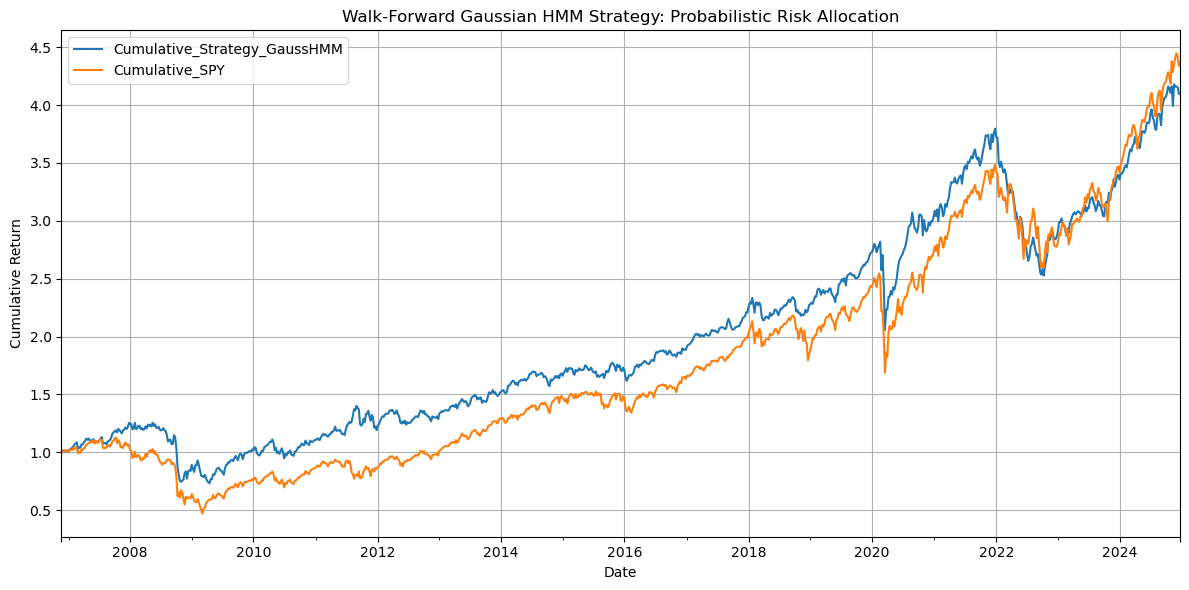

In [6]:
strategy_df_gauss[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def compute_stats(returns, freq='W'):
    periods_per_year = {'D': 252, 'W': 52, 'M': 12}[freq]

    #CAGR
    cumulative_return = (1 + returns).prod()
    n_periods = len(returns)
    years = n_periods / periods_per_year
    cagr = cumulative_return ** (1 / years) - 1

    #Max and average drawdown
    rolling = (1 + returns).cumprod()
    peak = rolling.cummax()
    drawdown = (rolling - peak) / peak
    max_dd = drawdown.min()
    avg_dd = drawdown[drawdown < 0].mean()

    #Sharpe Ratio
    volatility = returns.std() * np.sqrt(periods_per_year)  #for simplicity risk free rate is 0
    sharpe = returns.mean() / returns.std() * np.sqrt(periods_per_year) 
    return {
        'CAGR': cagr,
        'Max Drawdown': max_dd,
        'Average Drawdown': avg_dd,
        'Sharpe Ratio': sharpe
    }

In [8]:
stats_strategy_gauss = compute_stats(strategy_df_gauss['Strategy_Return_GaussHMM'], freq='W')
stats_spy = compute_stats(strategy_df_gauss['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_gauss['GLD_Return'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gauss, stats_spy],
    index=['GaussHMM strategy', 'SPY']
)
print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.0807       -0.4170           -0.0913        0.5923
SPY                0.0845       -0.5836           -0.1289        0.5343


### Results commentary
- CAGR trade-off: Slightly lower than pure SPY, as the defensive approach gives up some upside during strong bull markets..
- Max Drawdown materially improved.
- Average Drawdown lower.
- Higher Sharpe indicate better return per unit volatility.

While these results show meaningful risk-adjusted outperformance versus SPY, using it as the sole benchmark may overstate the gains.
A more balanced and realistic comparison is the static 50/50 SPY–GLD portfolio, which incorporates built-in diversification and provides a fairer baseline for evaluating the strategy’s added value.

**Why use 50/50 benchmark?**
- Acts as a low information prior: equal capital weighting across growth & hedge asset.
- It represents a simple, transparent allocation that many investors could implement without modeling or forecasting.
- Provides a realistic hurdle: any regime-switching strategy should deliver tangible improvements over this diversified buy and hold mix to justify its additional complexity and transaction costs.

In [9]:
strategy_df_gauss['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_gauss['SPY_Return']) + 0.5 * np.exp(strategy_df_gauss['GLD_Return']) )
strategy_df_gauss['Cumulative_Mixed'] = (1+strategy_df_gauss['Mixed_Returns']).cumprod()

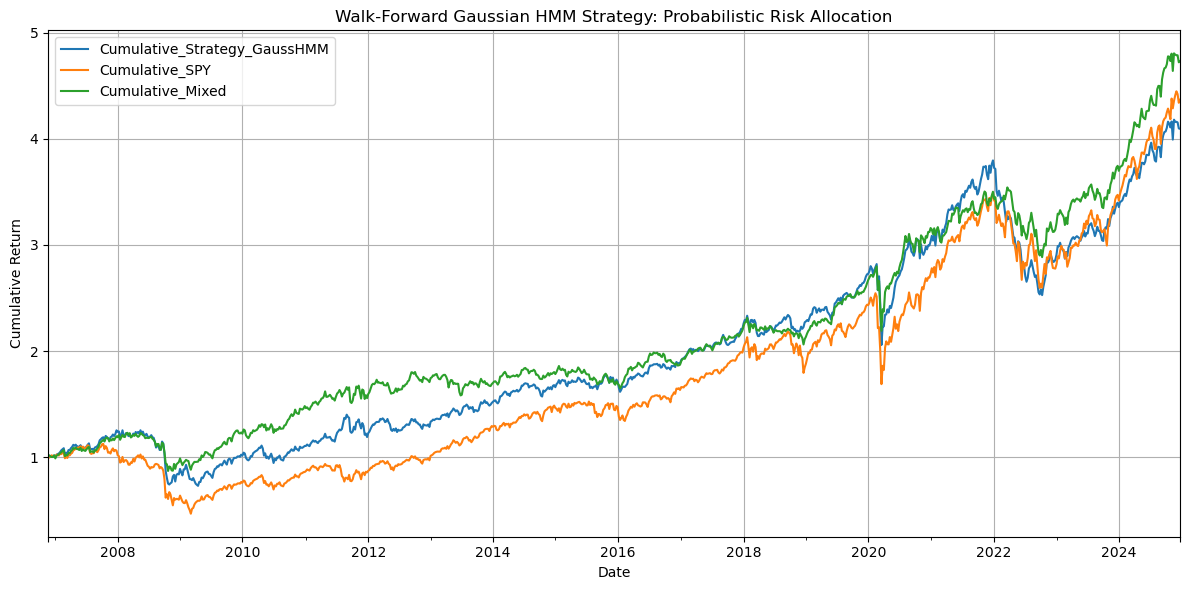

In [10]:
strategy_df_gauss[['Cumulative_Strategy_GaussHMM', 'Cumulative_SPY','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward Gaussian HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
stats_mixed = compute_stats(strategy_df_gauss['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gauss, stats_spy, stats_gld, stats_mixed],
    index=['GaussHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                     CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GaussHMM strategy  0.0807       -0.4170           -0.0913        0.5923
SPY                0.0845       -0.5836           -0.1289        0.5343
GLD                0.0629       -0.4805           -0.2244        0.4498
50/50              0.0893       -0.2924           -0.0482        0.7304


### Results commentary
The Gaussian HMM improves drawdowns and Sharpe ratio compared to SPY, but fails to outperform the 50/50 SPY–GLD benchmark, which delivers both higher CAGR and superior risk-adjusted returns.
Given that financial returns often deviate from the Gaussian assumption, exhibiting fat tails and skew, we next replace the normal emissions with a Gaussian Mixture Model HMM (GMM-HMM) to better capture extreme events and potentially close the gap versus the mixed strategy benchmark.

# GMM-HMM Strategy (Mixture Emissions)
This model could allow us to retain 2 interpretable macro regimes while increasing flexibility of return distribution modeling using a mixture of 3 Gaussians per state.


In [12]:
#Define the parameters and the HMM model
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
n_mix = 3 #number of Gaussian
strategy_returns_GMMHMM = []

#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #Select only data from the window selected
    train_data = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    # scaler = StandardScaler()
    # train_data = scaler.fit_transform(train_data[['SPY_Returns']])

    model = GMMHMM(n_components=n_components, n_mix = n_mix, covariance_type='tied', n_iter=100, random_state=1806)
    model.fit(train_data[['SPY_Returns']].values)

    #Transition probability
    posteriors = model.predict_proba(train_data[['SPY_Returns']].values)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data[['SPY_Returns']].values)
    train_data = train_data.copy()
    train_data['State'] = states

    state_returns = train_data.groupby('State')['SPY_Returns'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY_Returns']
    r_gld = df_returns.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

In [13]:
strategy_df_gmm = pd.DataFrame(strategy_returns_GMMHMM, columns=[ 'Date', 'Strategy_Return_GMMHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_gmm.set_index( 'Date', inplace=True)
strategy_df_gmm['Cumulative_Strategy_GMMHMM'] = (1+strategy_df_gmm['Strategy_Return_GMMHMM']).cumprod()
strategy_df_gmm['Cumulative_SPY'] = (1 + strategy_df_gmm ['SPY_Return']).cumprod()
strategy_df_gmm['Cumulative_GLD'] = (1 + strategy_df_gmm ['GLD_Return']).cumprod()
strategy_df_gmm['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_gmm['SPY_Return']) + 0.5 * np.exp(strategy_df_gmm['GLD_Return']) )
strategy_df_gmm['Cumulative_Mixed'] = (1+strategy_df_gmm['Mixed_Returns']).cumprod()

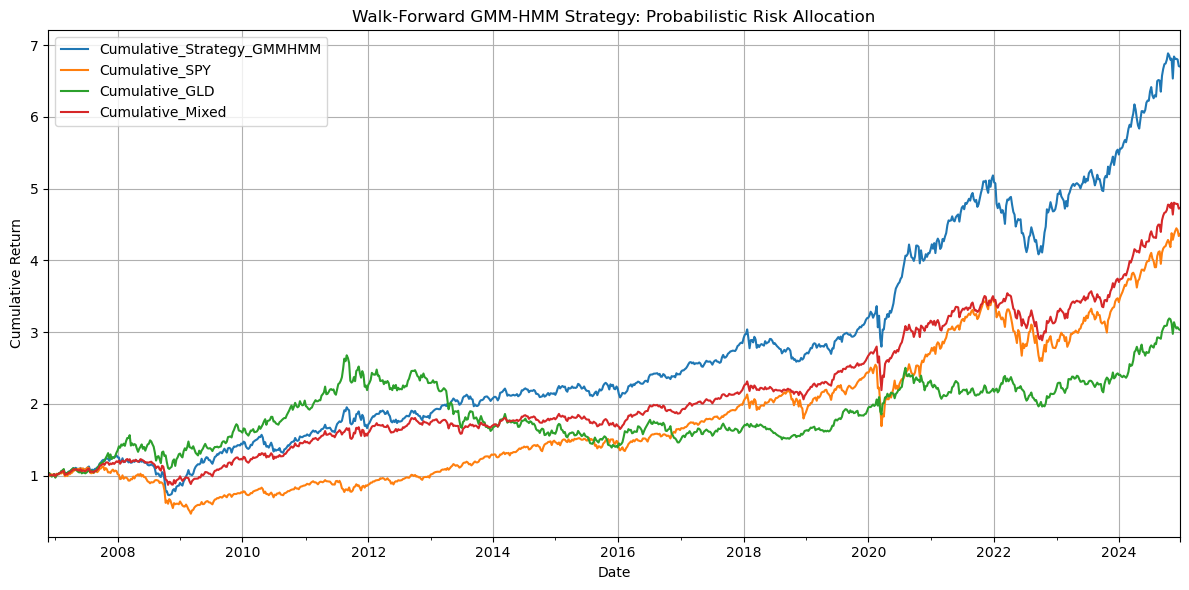

In [14]:
strategy_df_gmm[['Cumulative_Strategy_GMMHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward GMM-HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
stats_strategy_gmm = compute_stats(strategy_df_gmm['Strategy_Return_GMMHMM'], freq='W')
stats_spy = compute_stats(strategy_df_gmm['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_gmm['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df_gmm['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gmm, stats_spy, stats_gld, stats_mixed],
    index=['GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                   CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GMMHMM strategy  0.1104       -0.4332           -0.0602        0.7896
SPY              0.0845       -0.5836           -0.1289        0.5343
GLD              0.0629       -0.4805           -0.2244        0.4498
50/50            0.0893       -0.2924           -0.0482        0.7304


### Results Commentary:
The GMM-HMM strategy clearly outperforms both SPY and the 50/50 benchmark in terms of growth and risk-adjusted returns.
CAGR is clearly higher, Sharpe ratio reaches its best level so far, and drawdowns are substantially reduced compared to SPY, though still larger than the very defensive 50/50 mix.
These results confirm that allowing for fat tailed distributions improves regime detection and portfolio performance.

Next, we move to a bivariate model, adding rolling volatility as a second feature to see if incorporating both return and volatility regimes can further enhance results.

# Bivariate GMM-HMM

In [16]:
#Compute Volatility 
df_returns_biv = df_returns.copy()
df_returns_biv['Volatility'] = df_returns_biv['SPY_Returns'].rolling(window=4).std()
df_returns_biv.dropna(inplace=True)

In [17]:
#Define the parameters and the HMM model
window_size_biv = 104   # 208 weeks
n_components_biv = 2    #The two states are the two regimes
n_mix_biv = 3 #number of Gaussian
strategy_returns_GMMHMM_biv = []
exception_count = 0

#Walk forward loop
for i in range(window_size_biv, len(df_returns_biv)-1):

    #Select only data from the window selected
    train_data = df_returns_biv.iloc[i - window_size_biv:i]
    test_index = df_returns_biv.index[i]

    X_train = train_data[['SPY_Returns','Volatility']].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    #print("DEBUG: X_train_scaled shape:", X_train_scaled.shape)
    #print("DEBUG: X_train_scaled std:", np.std(X_train_scaled, axis=0))

    try:
        model = GMMHMM(n_components = n_components_biv, n_mix = n_mix_biv, covariance_type='diag', n_iter=100, random_state=1806)
        model.fit(X_train_scaled)

        #Transition probability
        posteriors = model.predict_proba(X_train_scaled)
        pi_t = posteriors[-1]   #Vector with the probablity of being in each state
        pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

        #Predict states
        states = model.predict(X_train)  
        train_data=train_data.copy()
        train_data['State'] = states

        state_returns = train_data.groupby('State')['SPY_Returns'].mean()
        high_risk_state = state_returns.idxmin()

        #Asset allocation
        weight_gld = pi_next[high_risk_state]
        weight_spy = 1 - weight_gld
    except:
        weight_gld = 0.5
        weight_spy = 0.5
        exception_count += 1

    r_spy = df_returns_biv.loc[test_index, 'SPY_Returns']
    r_gld = df_returns_biv.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM_biv.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

In [18]:
strategy_df_biv = pd.DataFrame(strategy_returns_GMMHMM_biv, columns=[ 'Date', 'Strategy_Return_GMMHMM_biv', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_biv.set_index( 'Date', inplace=True)
strategy_df_biv['Cumulative_Strategy_GMMHMM_biv'] = (1+strategy_df_biv['Strategy_Return_GMMHMM_biv']).cumprod()
strategy_df_biv['Cumulative_SPY'] = (1 + strategy_df_biv['SPY_Return']).cumprod()
strategy_df_biv['Cumulative_GLD'] = (1 + strategy_df_biv['GLD_Return']).cumprod()
strategy_df_biv['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_biv['SPY_Return']) + 0.5 * np.exp(strategy_df_biv['GLD_Return']) )
strategy_df_biv['Cumulative_Mixed'] = (1+strategy_df_biv['Mixed_Returns']).cumprod()

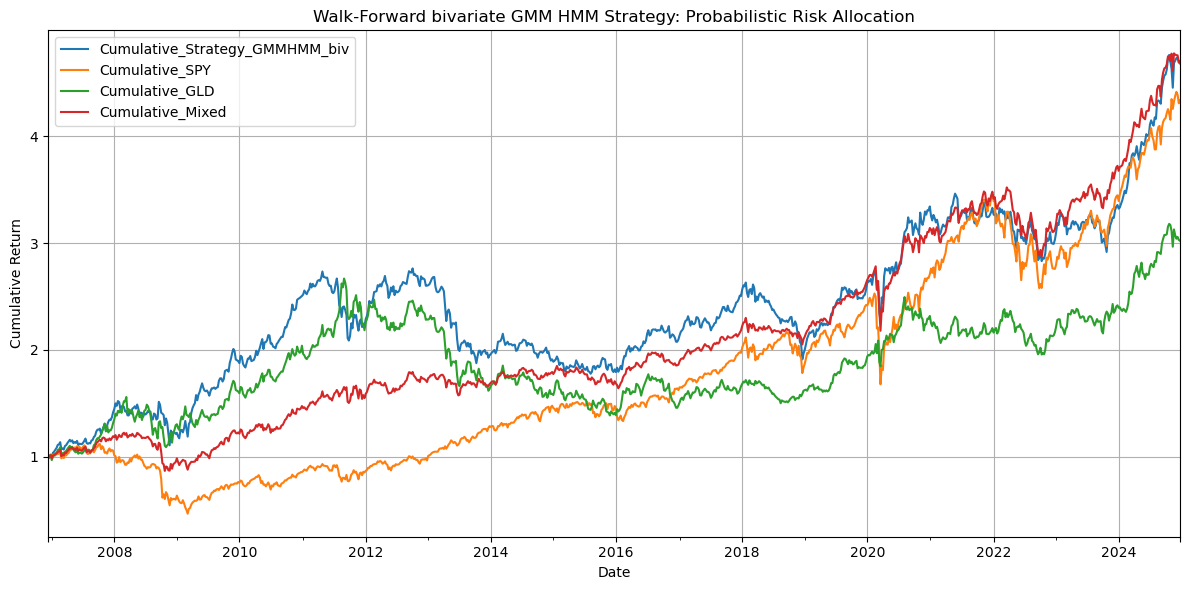

In [19]:
strategy_df_biv[['Cumulative_Strategy_GMMHMM_biv', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward bivariate GMM HMM Strategy: Probabilistic Risk Allocation")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
stats_strategy_biv = compute_stats(strategy_df_biv['Strategy_Return_GMMHMM_biv'], freq='W')
stats_spy = compute_stats(strategy_df_biv['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_biv['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df_biv['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_biv, stats_spy, stats_gld, stats_mixed],
    index=['Biv GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                       CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
Biv GMMHMM strategy  0.0890       -0.3571           -0.1309        0.6206
SPY                  0.0844       -0.5836           -0.1290        0.5331
GLD                  0.0629       -0.4805           -0.2257        0.4499
50/50                0.0892       -0.2924           -0.0483        0.7294


### Results commentary
The bivariate GMM-HMM model, which adds rolling volatility as a second feature, fails to improve performance.
CAGR is on par with the 50/50 benchmark but lower than the univariate GMM-HMM, Sharpe ratio drops, and drawdown metrics worsen relative to the best previous model.
This suggests that, in this implementation, the added volatility signal introduces noise rather than enhancing regime detection.
We therefore retain the univariate GMM-HMM as the preferred version going forward.

Up to this point, benchmarks have been based on price only SPY data, which exclude dividends.
Comparing to a price only benchmark understates the benchmark’s true performance.
To address this, we replace SPY with the S&P 500 Total Return Index (^SP500TR) as a proxy for SPY total return.
This adjustment provides a fairer comparison and serves as a robustness check: by boosting the benchmark’s CAGR, it may narrow or even eliminate the observed outperformance, revealing whether the strategy’s edge is genuine.

# Dividend adjusted benchmark

In [21]:
import yfinance as yf
import pandas as pd

#Download S&P 500 Total Return
sp500tr = yf.download("^SP500TR", start="2000-01-01", end="2024-12-31")
sp500tr.to_csv("data/sp500_total_return.csv") 

[*********************100%***********************]  1 of 1 completed


In [22]:
spy_tr = pd.read_csv("data/sp500_total_return.csv", header=[0, 1], index_col=0)
spy_tr.columns = spy_tr.columns.get_level_values(0)   # flatten multi-index
spy_tr.index = pd.to_datetime(spy_tr.index)

spy_tr_weekly = spy_tr['Close'].resample('W-FRI').last()

spy_tr_returns = np.log(spy_tr_weekly / spy_tr_weekly.shift(1)).dropna().to_frame(name='SPY_TR_Returns')

df_returns = df_returns.join(spy_tr_returns, how='left')

print(df_returns.head())

            SPY_Returns  GLD_Returns  SPY_TR_Returns
Date                                                
2004-11-26     0.007890     0.011325        0.010690
2004-12-03     0.007575     0.006821        0.007694
2004-12-10     0.000671    -0.048527       -0.002335
2004-12-17     0.005634     0.017118        0.005477
2004-12-24     0.011073     0.001809        0.013619


In [23]:
window_size = 104   # 104 weeks
n_components = 2    #The two states are the two regimes
n_mix = 3 #number of Gaussian
strategy_returns_GMMHMM = []

#Walk forward loop
for i in range(window_size, len(df_returns) - 1):

    #Select only data from the window selected
    train_data = df_returns.iloc[i - window_size:i]
    test_index = df_returns.index[i]

    model = GMMHMM(n_components=n_components, n_mix = n_mix, covariance_type='tied', n_iter=100, random_state=1806)
    model.fit(train_data[['SPY_Returns']].values)

    #Transition probability
    posteriors = model.predict_proba(train_data[['SPY_Returns']].values)
    pi_t = posteriors[-1]   #Vector with the probablity of being in each state
    pi_next = pi_t @ model.transmat_    #Get the prob of being in each state in the next step

    #Predict states
    states = model.predict(train_data[['SPY_Returns']].values)
    train_data = train_data.copy()
    train_data['State'] = states

    state_returns = train_data.groupby('State')['SPY_Returns'].mean()
    high_risk_state = state_returns.idxmin()

    #Asset allocation
    weight_gld = pi_next[high_risk_state]
    weight_spy = 1 - weight_gld

    r_spy = df_returns.loc[test_index, 'SPY_TR_Returns']    #WE USE THE SPY TOTAL RETURN FOR COMPUTING THE RETURNS
    r_gld = df_returns.loc[test_index, 'GLD_Returns']
    strategy_return = np.log(weight_spy * np.exp(r_spy) + weight_gld * np.exp(r_gld) )

    strategy_returns_GMMHMM.append((test_index, strategy_return, r_spy, r_gld, weight_gld))

In [24]:
strategy_df_gmm = pd.DataFrame(strategy_returns_GMMHMM, columns=[ 'Date', 'Strategy_Return_GMMHMM', 'SPY_Return', 'GLD_Return', 'GLD_Weight'])
strategy_df_gmm.set_index( 'Date', inplace=True)
strategy_df_gmm['Cumulative_Strategy_GMMHMM'] = (1+strategy_df_gmm['Strategy_Return_GMMHMM']).cumprod()
strategy_df_gmm['Cumulative_SPY'] = (1 + strategy_df_gmm ['SPY_Return']).cumprod()
strategy_df_gmm['Cumulative_GLD'] = (1 + strategy_df_gmm ['GLD_Return']).cumprod()
strategy_df_gmm['Mixed_Returns'] = np.log( 0.5 * np.exp(strategy_df_gmm['SPY_Return']) + 0.5 * np.exp(strategy_df_gmm['GLD_Return']) )
strategy_df_gmm['Cumulative_Mixed'] = (1+strategy_df_gmm['Mixed_Returns']).cumprod()

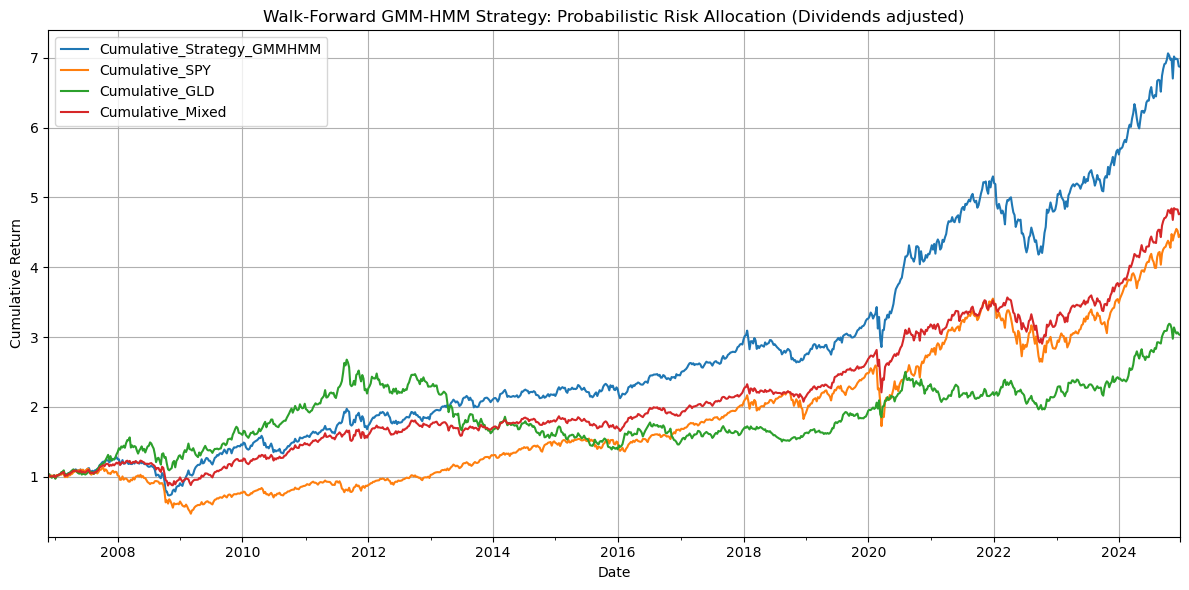

In [25]:
strategy_df_gmm[['Cumulative_Strategy_GMMHMM', 'Cumulative_SPY','Cumulative_GLD','Cumulative_Mixed']].plot(figsize=(12, 6))
plt.title("Walk-Forward GMM-HMM Strategy: Probabilistic Risk Allocation (Dividends adjusted)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
stats_strategy_gmm = compute_stats(strategy_df_gmm['Strategy_Return_GMMHMM'], freq='W')
stats_spy = compute_stats(strategy_df_gmm['SPY_Return'], freq='W')
stats_gld = compute_stats(strategy_df_gmm['GLD_Return'],freq='W' )
stats_mixed = compute_stats(strategy_df_gmm['Mixed_Returns'],freq='W' )

report = pd.DataFrame(
    [stats_strategy_gmm, stats_spy, stats_gld, stats_mixed],
    index=['GMMHMM strategy', 'SPY', 'GLD','50/50']
)

print(report.round(4))

                   CAGR  Max Drawdown  Average Drawdown  Sharpe Ratio
GMMHMM strategy  0.1119       -0.4290           -0.0595        0.8025
SPY              0.0858       -0.5816           -0.1269        0.5435
GLD              0.0629       -0.4805           -0.2244        0.4498
50/50            0.0897       -0.2900           -0.0481        0.7365


### Final Results and Conclusions
Result: The GMM-HMM strategy maintains a clear edge versus the dividend-adjusted benchmarks, delivering higher CAGR, improved Sharpe ratio, and meaningfully reduced drawdowns compared to SPY.
While the 50/50 SPY–GLD portfolio remains extremely competitive in drawdown control, the model achieves superior growth and risk-adjusted returns, validating the probabilistic hedging approach.

Strengths:
- Transparent allocation rule (probability-weighted hedge) avoids overfitting signals.
- Mixture emissions capture non-Gaussian return structure without exploding state space.
- Walk-forward design reduces look-ahead risk (mimics live deployment).

Limitations:
- Hyperparameters (window=104, states=2, n_mix=3) not tuned systematically.
- No cost or slippage modeling; real-world performance would be lower.

Conclusion:
The mixture-based univariate HMM stands out as the most effective configuration, consistently outperforming both price only and dividend adjusted benchmarks on a risk-adjusted basis.
Multivariate extensions did not yield incremental value.
Overall, results represent credible progress toward systematic alpha generation, though multiple refinement layers remain before a production ready deployment.

**Daje *(Italian for "Let's go")* , we're one step closer to systematic alpha !!**